In [121]:
import pandas as pd
import geopandas as gpd
import requests
import rasterio as rio
import rasterio.plot
import requests
import shapely.wkb
import numpy as np
from rasterstats import zonal_stats
from shapely.geometry import Polygon, Point, MultiPolygon
from matplotlib import pyplot as plt
import os

# Sample input data

In [103]:
sample_data = gpd.GeoDataFrame([
    {
        'location': 'California',
        'geometry': None,
        'raw material': 'almonds',
        'tonnage': 150,
        'year':2017
    },
    {
        'location': 'Flour mill',
        'geometry': None,
        'raw material': 'wheat flour',
        'tonnage': 21000,
        'year':2017
    }
])
sample_data.head()

,geometry,location,raw material,tonnage,year
0,None,California,almonds,150,2017
1,None,Flour supplier,wheat flour,21000,2017


# Get geometries

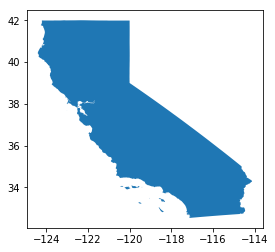

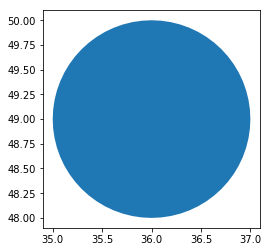

In [104]:
queryUrl = 'https://api.resourcewatch.org/v1/query/Politcial-Boundaries-GADM-adminitrative-level-1-1490086842541'
queryParams = {'sql': "select the_geom from gadm28_adm1 where name_1='California'"}

resp = requests.get(queryUrl, queryParams)
cali_geom = shapely.wkb.loads(resp.json()['data'][0]['the_geom'], hex=True)

sample_data.at[0, 'geometry'] = cali_geom
sample_data.at[1, 'geometry'] = Point(36, 49).buffer(1)

sample_data[sample_data.index==0].plot()
sample_data[sample_data.index==1].plot()

In [105]:
# Download data

In [106]:
!curl -O https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/wheat_HarvAreaYield_Geotiff.zip
!curl -O https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/almond_HarvAreaYield_Geotiff.zip
!curl -O http://data.wri.org/Aqueduct/web/aqueduct_global_maps_21_shp.zip
!unzip -oq wheat_HarvAreaYield_Geotiff.zip
!unzip -oq almond_HarvAreaYield_Geotiff.zip
!unzip -oq aqueduct_global_maps_21_shp.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  1327k      0  0:00:07  0:00:07 --:--:-- 1041k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4065k  100 4065k    0     0   781k      0  0:00:05  0:00:05 --:--:--  840k:00:02  0:00:02  970k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73.1M  100 73.1M    0     0   861k      0  0:01:27  0:01:27 --:--:--  941k36 26.5M    0     0  1296k      0  0:00:57  0:00:20  0:00:37  679k9k      0  0:00:58  0:00:22  0:00:36  934k7k      0  0:01:25  0:00:45  0:00:40  230k 0  0:01:31  0:00:52  0:00:39  469kk      0  0:01:31  0:01:06  0:00:25  894k


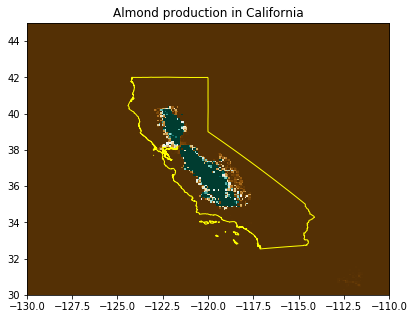

In [107]:
with rio.open('almond_HarvAreaYield_Geotiff/almond_Production.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((30,45))
    ax.set_xlim((-130,-110))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    sample_data[sample_data.index==0].plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Almond production in California')

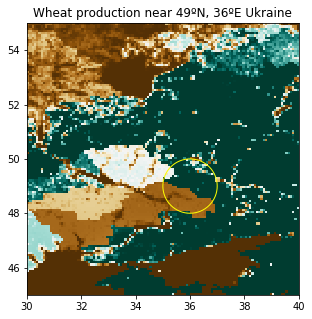

In [108]:
with rio.open('wheat_HarvAreaYield_Geotiff/wheat_Production.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((45,55))
    ax.set_xlim((30,40))
    rio.plot.show(dat, vmax=1000, cmap='BrBG', ax=ax, transform=src.transform)
    sample_data[sample_data.index==1].plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Wheat production near 49ºN, 36ºE Ukraine')

In [109]:
bws = gpd.read_file("aqueduct_global_dl_20150409.shp")
bws.head()

,GU,Shape_Leng,Shape_Area,BasinID,COUNTRY,BASIN_NAME,WITHDRAWAL,CONSUMPTIO,BA,BWS,...,W_CHEM,W_POWER,W_MINE,W_OILGAS,DEF_PQUANT,W_AGR,W_FOODBV,W_TEX,OWR_cat,geometry
0,1,0.559986,0.005929,439,Guinea Bissau,None,318530368.0,2.191088e+08,9.921439e+09,0.032105,...,2.882769,1.652696,2.817264,3.574223,0.953074,1.674275,2.102334,1.782311,Low to medium risk (1-2),(POLYGON ((-14.75229565619014 12.6188368125272...
1,2,2.272372,0.099605,441,Guinea Bissau,None,14757104.0,5.604148e+06,5.116468e+09,0.002884,...,2.841154,1.564447,2.664640,3.529458,0.826442,1.600816,2.142925,1.746387,Low to medium risk (1-2),(POLYGON ((-16.13767726797875 12.2940957333858...
2,3,0.610379,0.017086,444,Guinea,GEBA,34460596.0,1.764853e+07,9.535255e+09,0.003614,...,2.774803,1.551692,2.707415,3.352587,0.891978,1.582219,2.270701,1.773006,Low to medium risk (1-2),POLYGON ((-13.56238156611261 12.66742547396541...
3,4,5.384966,0.636739,444,Guinea Bissau,GEBA,34460596.0,1.764853e+07,9.535255e+09,0.003614,...,2.897160,1.571053,2.834815,3.544556,0.891978,1.660348,2.335788,1.858815,Medium to high risk (2-3),POLYGON ((-13.73217699483075 12.57834249376896...
4,5,1.815190,0.055072,446,Guinea Bissau,None,6855107.0,2.852844e+06,1.839854e+09,0.003726,...,2.878972,1.549313,2.687177,3.524936,0.819780,1.629414,2.316616,1.815062,Low to medium risk (1-2),(POLYGON ((-15.72857010960513 11.9712600703465...


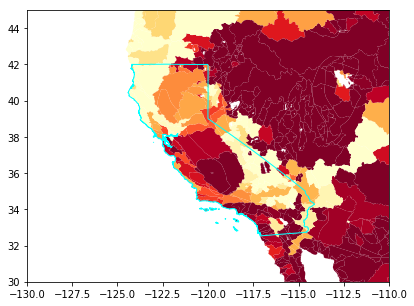

In [110]:
fig, ax = plt.subplots(figsize=[10,5])
ax.set_ylim((30,45))
ax.set_xlim((-130,-110))
bws.plot(ax=ax, column='BWS_s', cmap='YlOrRd', vmin=0, vmax=5)
sample_data[sample_data.index==0].plot(ax=ax, color='', edgecolor='cyan')

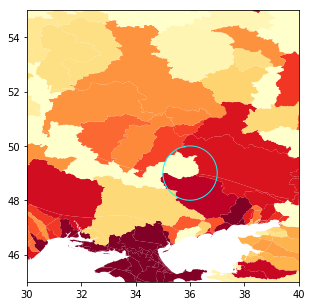

In [111]:
fig, ax = plt.subplots(figsize=[10,5])
ax.set_ylim((45,55))
ax.set_xlim((30,40))
bws.plot(ax=ax, column='BWS_s', cmap='YlOrRd', vmin=0, vmax=5)
sample_data[sample_data.index==1].plot(ax=ax, color='', edgecolor='cyan')

# Calculate weighted average of BWS

In [114]:
rastermapping = {
    'wheat flour':'wheat_HarvAreaYield_Geotiff/wheat_Production.tif',
    'almonds':'almond_HarvAreaYield_Geotiff/almond_Production.tif'
}

avg_bws = []

for idx, row in sample_data.iterrows():
    
    # clip the aqueduct basins to the geometry
    sample_data[sample_data.index==idx].to_file('geom')
    !mapshaper -i 'aqueduct_global_dl_20150409.shp' -clip 'geom/geom.shp' -o 'clipped.geojson'
    
    # calculate the sum of weights (crop production) for each basin
    zs = zonal_stats('clipped.geojson', rastermapping[row['raw material']], stats=['sum'], geojson_out=True)
    aqueduct_stats = gpd.GeoDataFrame.from_features(zs)
    aqueduct_stats = aqueduct_stats[aqueduct_stats['BWS'].notna()]
    
    # calculate weighted average
    avg_bws.append((aqueduct_stats['BWS']*aqueduct_stats['sum']).sum() / aqueduct_stats['sum'].sum())

sample_data['avg_bws'] = avg_bws
sample_data.head()

[o] Wrote clipped.geojson


/usr/local/homebrew/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[o] Wrote clipped.geojson


/usr/local/homebrew/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,geometry,location,raw material,tonnage,year,avg_bws
0,(POLYGON ((-117.2328491210937 32.7764053344726...,California,almonds,150,2017,1.509370
1,"POLYGON ((37 49, 36.9951847266722 48.901982859...",Flour supplier,wheat flour,21000,2017,0.506039


In [ ]:
# Calculate gap

In [120]:
# look up water footprint from table (here hardcoded)
water_withdrawals_ton = {
    'wheat flour': 299,
    'almonds': 7268
}
sample_data['withdrawal_ton'] = sample_data['raw material'].apply(lambda x:water_withdrawals_ton[x])

# calculate total withdrawals
sample_data['total_withdrawal'] = sample_data['tonnage'] * sample_data['withdrawal_ton']
sample_data.head()

,geometry,location,raw material,tonnage,year,avg_bws,withdrawal_ton,total_withdrawal
0,(POLYGON ((-117.2328491210937 32.7764053344726...,California,almonds,150,2017,1.509370,7268,1090200
1,"POLYGON ((37 49, 36.9951847266722 48.901982859...",Flour supplier,wheat flour,21000,2017,0.506039,299,6279000


In [129]:
excess_bws = (sample_data['avg_bws']-0.4)/sample_data['avg_bws']
excess_bws[excess_bws<0] = 0

sample_data['gap'] = excess_bws * sample_data['total_withdrawal']
sample_data.to_csv('output.csv')
sample_data.head()

,geometry,location,raw material,tonnage,year,avg_bws,withdrawal_ton,total_withdrawal,gap
0,(POLYGON ((-117.2328491210937 32.7764053344726...,California,almonds,150,2017,1.509370,7268,1090200,8.012848e+05
1,"POLYGON ((37 49, 36.9951847266722 48.901982859...",Flour supplier,wheat flour,21000,2017,0.506039,299,6279000,1.315744e+06
